# Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/NeuraVisionLib/')
## ! git reset --hard
# ! git pull

while not 'dataloaders' in os.listdir():
    os.chdir('../')
# os.listdir()

In [ ]:
import os
os.listdir('../../../MyDrive/mass_dataset/')

In [ ]:
! pip install rasterio > install.txt
! rm -rf install.txt

# Main

In [1]:
import os
while not 'dataloaders' in os.listdir():
    os.chdir('../')

In [2]:
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from dataloaders.mass_roads_dataloader import MassRoadsDataset, custom_collate_fn
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork

# --- Hyperparameters ---
DATA_DIR = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'
CHECKPOINT_PATH = 'checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth'
BEST_MODEL_PATH = 'checkpoints/RoadSegMulde/best_log_density_segmentation_model.pth'
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
EPOCHS = 300
ACCUMULATION_STEPS = 8
WINDOW_SIZE = 128
WINDOW_STRIDE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA_MIN = 0.01
SIGMA_MAX = 0.3
NUM_NOISE_LEVELS = 10
USE_AUTOMATIC_MIXED_PRECISION = True
LOAD_FROM = None #'last' # best or None
# Generate noise levels
noise_levels = torch.logspace(
    start=torch.log10(torch.tensor(SIGMA_MIN)),
    end=torch.log10(torch.tensor(SIGMA_MAX)),
    steps=NUM_NOISE_LEVELS
).to(DEVICE)

# --- Dataset Preparation ---
train_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='train', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=3)
val_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='valid', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=3)
test_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='test', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE)#, max_images=3)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

# --- Save and Load Model ---
def save_model(log_density_model, optimizer, epoch, loss, path):
    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': log_density_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Model saved at {path}")

def load_checkpoint(path):
    if os.path.exists(path):
        checkpoint = torch.load(path)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']
    return 0, None

# --- Loss Functions ---
def dice_loss(pred, target, smooth=1e-6):
    """
    Dice Loss for binary segmentation.
    """
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    dice = 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss to focus on harder examples.
    """
    bce = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)
    pt = torch.exp(-bce)  # Probabilities
    focal = alpha * (1 - pt)**gamma * bce
    return focal.mean()

def weighted_bce_loss(logits, targets, pos_weight=1.0):
    """
    Weighted Binary Cross Entropy to address class imbalance.
    """
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(logits.device))
    return bce(logits, targets)

def hybrid_loss(predictions, targets, alpha=0.5, beta=0.5, gamma=2.0, use_focal=True):
    """
    Hybrid Loss combining Weighted BCE, Dice Loss, and optionally Focal Loss.
    """
    # Calculate class weights dynamically
    num_positive = targets.sum()
    num_negative = targets.numel() - num_positive
    pos_weight = num_negative / (num_positive + 1e-6)  # Avoid division by zero

    # Weighted BCE Loss
    bce = weighted_bce_loss(predictions, targets, pos_weight=pos_weight)

    # Dice Loss
    dice = dice_loss(predictions, targets)

    # Focal Loss (optional)
    focal = focal_loss(predictions, targets) if use_focal else 0

    # Weighted combination of losses
    loss = alpha * bce + beta * dice + gamma * focal
    return loss


def calculate_metrics(predictions, targets, threshold=0.5):
    preds = (predictions > threshold).float().cpu().numpy().astype(np.uint8).flatten()
    targets = (targets > 0.5).float().cpu().numpy().astype(np.uint8).flatten()  # Ensure targets are binary
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    f1 = f1_score(targets, preds, zero_division=1)
    iou = jaccard_score(targets, preds, zero_division=1)

    return precision, recall, f1, iou

# --- Model Definition ---
resnet = resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-2],
    nn.AdaptiveAvgPool2d((1, 1))
).to(DEVICE)
for param in resnet.parameters():
    param.requires_grad = False

mlp = MLPs(
    input_dim=2048 + 1,
    output_dim=WINDOW_SIZE * WINDOW_SIZE,
    units=[4096, 4096],
    layernorm=True,
    dropout=0.1
)
log_density_model = ScoreOrLogDensityNetwork(mlp, score_network=False).to(DEVICE)

optimizer = optim.AdamW(log_density_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scaler = torch.amp.GradScaler() if USE_AUTOMATIC_MIXED_PRECISION else None

# --- Forward Pass ---
def forward_pass(satellite_patches, noise_levels, resnet, log_density_model):
    features = resnet(satellite_patches).flatten(start_dim=1)
    batch_size = features.size(0)
    num_noise_levels = len(noise_levels)
    features = features.repeat_interleave(num_noise_levels, dim=0)
    noise_tensor = noise_levels.repeat(batch_size, 1).view(-1, 1)
    features_with_noise = torch.cat([features, noise_tensor], dim=1)
    predictions = log_density_model(features_with_noise)
    return predictions.view(batch_size, num_noise_levels, 1, WINDOW_SIZE, WINDOW_SIZE)

# --- Training ---
def train_one_epoch(train_loader, resnet, log_density_model, noise_levels, optimizer, device, scaler, accumulation_steps):
    resnet.eval()
    log_density_model.train()
    epoch_loss = 0

    optimizer.zero_grad()
    for batch_idx, (satellite_patches, road_maps) in enumerate(tqdm(train_loader, desc="Training")):
        if satellite_patches.numel() == 0 or road_maps.numel() == 0:
            continue

        satellite_patches = satellite_patches.to(device)
        road_maps = road_maps.to(device).float() / 255.0  # Normalize ground truth
        road_maps = road_maps.unsqueeze(1)  # Add channel dimension

        if USE_AUTOMATIC_MIXED_PRECISION:
            with torch.amp.autocast(device_type='cuda'):
                predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
                predictions = predictions[:, 0, :, :, :]  # Use noise level 0
                loss = hybrid_loss(predictions, road_maps) / accumulation_steps
            scaler.scale(loss).backward()
        else:
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
            predictions = predictions[:, 0, :, :, :]
            loss = hybrid_loss(predictions, road_maps) / accumulation_steps
            loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            if USE_AUTOMATIC_MIXED_PRECISION:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


# --- Validation ---
def validate_one_epoch(val_loader, resnet, log_density_model, noise_levels, device):
    resnet.eval()
    log_density_model.eval()
    val_loss = 0
    metrics = []

    with torch.no_grad():
        for satellite_patches, road_maps in tqdm(val_loader, desc="Validation"):
            if satellite_patches.numel() == 0 or road_maps.numel() == 0:
                continue

            satellite_patches = satellite_patches.to(device)
            road_maps = road_maps.to(device).float() / 255.0  # Normalize ground truth
            road_maps = road_maps.unsqueeze(1)  # Add channel dimension

            # Forward pass
            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
            predictions = predictions[:, 0, :, :, :]  # Use predictions for noise level 0
            loss = hybrid_loss(predictions, road_maps)

            # Threshold predictions and calculate metrics
            precision, recall, f1, iou = calculate_metrics(torch.sigmoid(predictions), road_maps)
            metrics.append([precision, recall, f1, iou])

            val_loss += loss.item()

    # Average metrics
    avg_metrics = np.mean(metrics, axis=0)
    print(f"Validation - Precision: {avg_metrics[0]:.4f}, Recall: {avg_metrics[1]:.4f}, F1: {avg_metrics[2]:.4f}, IoU: {avg_metrics[3]:.4f}")
    return val_loss / len(val_loader), avg_metrics


# --- Test Evaluation ---
def evaluate_on_test(test_loader, resnet, log_density_model, noise_levels, device):
    resnet.eval()
    log_density_model.eval()
    test_loss = 0
    metrics = []

    with torch.no_grad():
        for satellite_patches, road_maps in tqdm(test_loader, desc="Testing"):
            if satellite_patches.numel() == 0 or road_maps.numel() == 0:
                continue

            satellite_patches = satellite_patches.to(device)
            road_maps = road_maps.to(device).float() / 255.0
            road_maps = road_maps.unsqueeze(1)

            predictions = forward_pass(satellite_patches, noise_levels, resnet, log_density_model)
            predictions = predictions[:, 0, :, :, :]
            loss = hybrid_loss(predictions, road_maps)

            precision, recall, f1, iou = calculate_metrics(torch.sigmoid(predictions), road_maps)
            metrics.append([precision, recall, f1, iou])
            test_loss += loss.item()

    avg_metrics = np.mean(metrics, axis=0)
    print(f"Test - Precision: {avg_metrics[0]:.4f}, Recall: {avg_metrics[1]:.4f}, F1: {avg_metrics[2]:.4f}, IoU: {avg_metrics[3]:.4f}")
    return test_loss / len(test_loader), avg_metrics

# --- Plot Predictions ---
def plot_predictions(predictions, ground_truth, satellite_images, n_samples=5):
    for i in range(min(n_samples, len(predictions))):
        pred = predictions[i].squeeze().cpu().numpy()
        gt = ground_truth[i].squeeze().cpu().numpy()
        sat_img = satellite_images[i].permute(1, 2, 0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(sat_img)
        axes[0].set_title('Satellite Image')
        axes[0].axis('off')

        axes[1].imshow(pred, cmap='gray')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

        axes[2].imshow(gt, cmap='gray')
        axes[2].set_title('Ground Truth')
        axes[2].axis('off')

        plt.show()

# --- Main Training Loop ---
def train_model(resnet, log_density_model, train_loader, val_loader, noise_levels, optimizer, scheduler, device, epochs, accumulation_steps, checkpoint_path, best_model_path, load_from='last'):
    best_val_loss = float('inf')
    start_epoch = 0

    # Decide whether to load from the last checkpoint or the best model
    if load_from == "last" and os.path.exists(checkpoint_path):
        print(f"Loading last checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        last_loss = checkpoint['loss']
        print(f"Resumed training from epoch {start_epoch} with last loss: {last_loss:.4f}")
    elif load_from == "best" and os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path}")
        best_model_checkpoint = torch.load(best_model_path)
        log_density_model.load_state_dict(best_model_checkpoint['model_state_dict'])
        optimizer.load_state_dict(best_model_checkpoint['optimizer_state_dict'])
        best_val_loss = best_model_checkpoint['loss']
        print(f"Best model loaded with validation loss: {best_val_loss:.4f}")
    elif load_from is not None:
        print(f"No checkpoint found for option '{load_from}'. Starting training from scratch.")
    else:
        print("Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_one_epoch(train_loader, resnet, log_density_model, noise_levels, optimizer, device, scaler, accumulation_steps)
        val_loss, avg_metrics = validate_one_epoch(val_loader, resnet, log_density_model, noise_levels, device)

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Precision: {avg_metrics[0]:.4f}, Recall: {avg_metrics[1]:.4f}, F1: {avg_metrics[2]:.4f}, IoU: {avg_metrics[3]:.4f}")

        scheduler.step()

        save_model(log_density_model, optimizer, epoch, val_loss, path=checkpoint_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(log_density_model, optimizer, epoch, val_loss, path=best_model_path)
            print(f"Best model updated with Validation Loss: {best_val_loss:.4f}")

    print("Training complete.")


Batch 1:
Sat Patches Shape: torch.Size([25, 3, 128, 128])
Map Patches Shape: torch.Size([25, 128, 128])


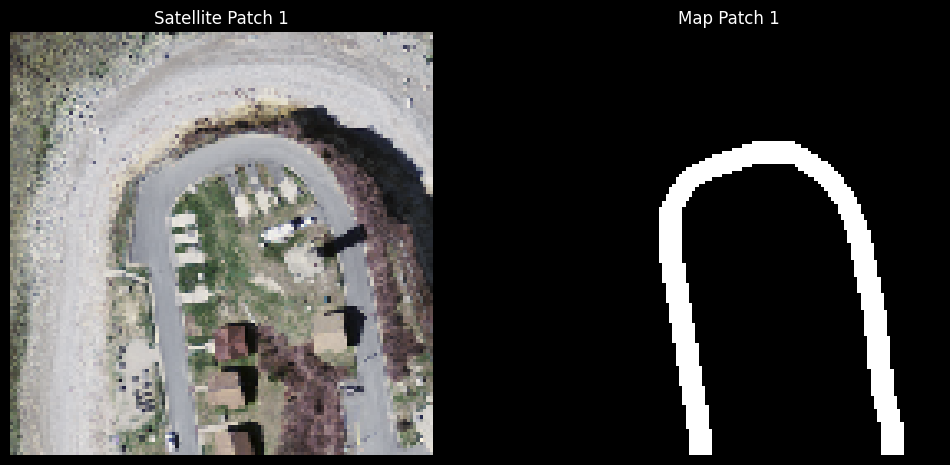

Batch 2:
Sat Patches Shape: torch.Size([104, 3, 128, 128])
Map Patches Shape: torch.Size([104, 128, 128])


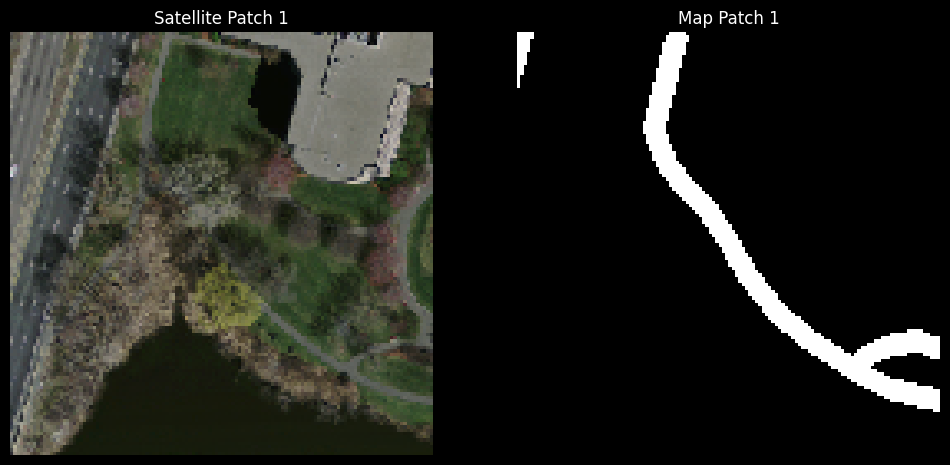

Batch 3:
Sat Patches Shape: torch.Size([389, 3, 128, 128])
Map Patches Shape: torch.Size([389, 128, 128])


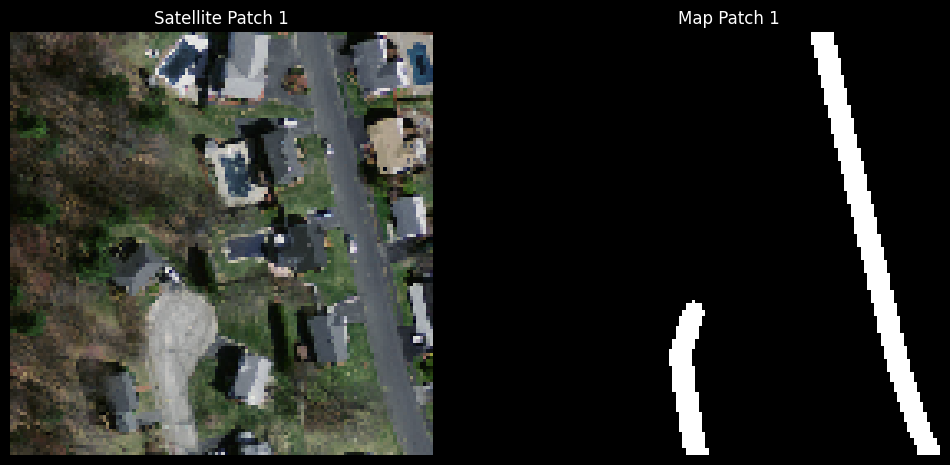

Batch 4:
Sat Patches Shape: torch.Size([42, 3, 128, 128])
Map Patches Shape: torch.Size([42, 128, 128])


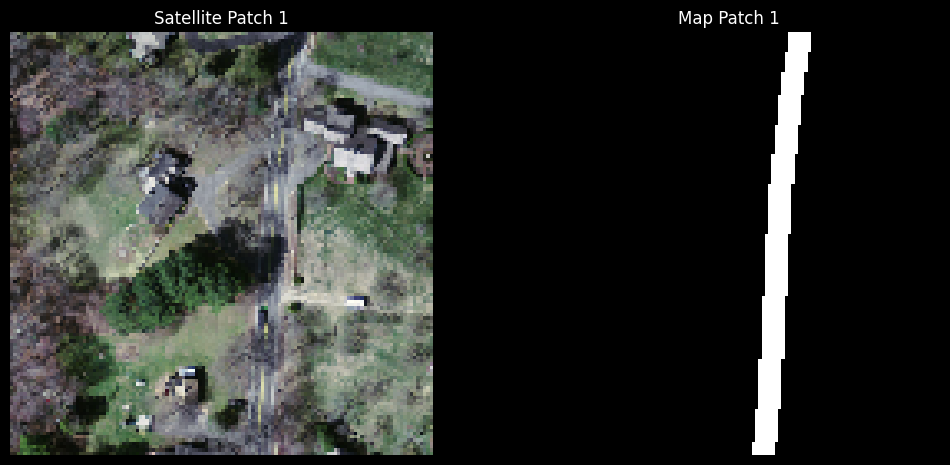

In [4]:
def plot_patches(sat_patches, map_patches, n_patches=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(min(n_patches, sat_patches.shape[0])):
        sat_patch = sat_patches[i].numpy().transpose(1, 2, 0) 
        map_patch = map_patches[i].numpy()

        ax[0].imshow(sat_patch)
        ax[0].set_title(f'Satellite Patch {i+1}')
        ax[0].axis('off')

        ax[1].imshow(map_patch, cmap='gray')
        ax[1].set_title(f'Map Patch {i+1}')
        ax[1].axis('off')

    plt.show()
for i, (sat_patches, map_patches) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Sat Patches Shape: {sat_patches.shape}")
    print(f"Map Patches Shape: {map_patches.shape}")

    plot_patches(sat_patches, map_patches, n_patches=1)
    if i > 2:
        break

In [ ]:

# --- Run Training ---
train_model(
    resnet=resnet,
    log_density_model=log_density_model,
    train_loader=train_loader,
    val_loader=val_loader,
    noise_levels=noise_levels,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_path=CHECKPOINT_PATH,
    best_model_path=BEST_MODEL_PATH,
    load_from=LOAD_FROM
)


Starting training from scratch.
Epoch 1/300


Training:  33%|███▎      | 368/1108 [04:21<07:50,  1.57it/s]

In [ ]:

# --- Evaluate on Test Set ---
test_loss, test_metrics = evaluate_on_test(
    test_loader=test_loader,
    resnet=resnet,
    log_density_model=log_density_model,
    noise_levels=noise_levels,
    device=DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics - Precision: {test_metrics[0]:.4f}, Recall: {test_metrics[1]:.4f}, F1: {test_metrics[2]:.4f}, IoU: {test_metrics[3]:.4f}")

# --- Visualize Predictions on Validation Set ---
val_batch = next(iter(val_loader))
sat_patches, road_maps = val_batch
sat_patches, road_maps = sat_patches.to(DEVICE), road_maps.to(DEVICE).float() / 255.0
road_maps = road_maps.unsqueeze(1)

with torch.no_grad():
    predictions = forward_pass(sat_patches, noise_levels, resnet, log_density_model)
    predictions = torch.sigmoid(predictions[:, 0, :, :, :])

plot_predictions(predictions, road_maps, sat_patches, n_samples=5)


In [ ]:
# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()
